In [1]:
##Do The Necessary Imports
## mplsoccer an absolute essential

import pandas as pd
import numpy as np
from mplsoccer.pitch import Pitch
import matplotlib.pyplot as plt
import json
import seaborn as sns

In [2]:
## A function that will return average location of players and the dataframe that has passing between pairs

def build_net(df , team) :
    ##Filter the df with only passes completed by the given team
    spain_passes = df[(df['type_name'] == 'Pass') & (df['team_name'] == team)][['location' , 'pass_end_location' , 'player_name' , 'pass_recipient_name' , 'minute']]
    
    ##Find 1st substitution

    minute = df[(df['type_name'] == 'Substitution') &(df['team_name'] == team)]['minute'].iloc[0]
    ##Consider passes till only 1st sub
    spain_passes = spain_passes[spain_passes['minute']<minute]
    
    spain_passes[['start_x','start_y']] = pd.DataFrame(spain_passes.location.tolist(), index= spain_passes.index)
    spain_passes[['end_x','end_y']] = pd.DataFrame(spain_passes.pass_end_location.tolist(), index= spain_passes.index)
    spain_passes.drop(['location' , 'pass_end_location'] , axis = 1 , inplace = True)
    
    
    
    ##Calculate average player positions based on the pass starting ppoints
    average_positions = spain_passes.groupby('player_name').mean()
    average_positions = average_positions.reset_index()
    average_positions = average_positions.drop(['end_x' , 'end_y'] , axis = 1)
    
    ## Accept the jersey numbers for the players.
    ##As they are not in the dataframe already
    jerseys = pd.DataFrame(columns = ['player_name' , 'number'])
    jerseys['player_name'] = average_positions['player_name']
    
    for player in range(len(average_positions)) :
        num = int(input(f"Enter jersey number for {average_positions.iloc[player]['player_name']}"))
        #jerseys['number'] = [21 , 1 , 19 , 22 , 3 , 18 , 8 , 4 , 20 , 5 , 15]
        jerseys.iloc[player]['number'] = num
    
    
    

    average_positions = average_positions.merge(jerseys , on = 'player_name')
    
    ##Create a dataframe for pair-wise passing
    passes_between = spain_passes.groupby(['player_name' , 'pass_recipient_name']).agg({'start_y': ['mean','count']}).reset_index()
    ##Get the number of passes made
    passes_count = passes_between['start_y' , 'count']
    
    passes_between['count'] = passes_count
    passes_between = passes_between.drop('start_y' , axis=1)
    passes_between
    passes_between.columns = [''.join(col) for col in passes_between.columns]
    
    ##Putting all the pieces together
    passes_between = passes_between.merge(average_positions , left_on='player_name' , right_on = 'player_name' )
    
    passes_between = passes_between.merge(average_positions , left_on='pass_recipient_name' , right_on = 'player_name' )
    
    
    passes_between.rename({'player_name_x': 'player_name'}, axis='columns', inplace=True)
    passes_between.rename({'start_x_x': 'start_x'}, axis='columns', inplace=True)
    passes_between.rename({'start_y_x': 'start_y'}, axis='columns', inplace=True)
    passes_between.rename({'start_x_y': 'end_x'}, axis='columns', inplace=True)
    passes_between.rename({'start_y_y': 'end_y'}, axis='columns', inplace=True)
    passes_between.rename({'number_x': 'start_number'}, axis='columns', inplace=True)
    passes_between.rename({'number_y': 'end_number'}, axis='columns', inplace=True)
    passes_between = passes_between.drop(['minute_x' , 'player_name_y', 'minute_y'] , axis=1)
    
    return passes_between , average_positions

    

In [3]:
##Function to draw the network
def draw_network(team1_passes , team1_avg , team2_passes , team2_avg , team1 , team2) :
    ##Passing Network for the 1st team
    
    pitch = Pitch(figsize=(30,30) , pitch_type='statsbomb' , pitch_color = '#22312b'  )
    
    fig = plt.figure(figsize=(40,40))
    ax1 = fig.add_subplot(211)
    pitch.draw(ax=ax1)

    pitch.scatter(team1_avg['start_x'] , team1_avg['start_y'] , ax = ax1 , s = 2500 , color = 'white')
    ##Loop through the average position df to plot the average location of each player
    for p in range(len(team1_avg)) :
        pitch.annotate(text = team1_avg.iloc[p]['number'] , xy = (team1_avg.iloc[p]['start_x'] , team1_avg.iloc[p]['start_y']) ,
                      ax=ax1 , c='#132743', va='center', ha='center', size=30, fontweight='bold', fontfamily="Century Gothic")

    ##We'll be plotting only passes between pairs that happened more than twice
    pass_between = team1_passes[team1_passes['count'] > 2]    
    pitch.arrows(pass_between['start_x'] , pass_between['start_y'] , pass_between['end_x'] , pass_between['end_y'] , ax = ax1 , color = 'white' ,
                alpha = 0.5)
    
    ##Describe 
    ax1.set_title(f"{team1} against {team2} | Until First Sub", fontsize=18, color="w", fontfamily="Andale Mono", fontweight='bold', pad=-30)
    
    
    
    
   
    
    
    
    ##Passing network for the 2nd team
    ax2 = fig.add_subplot(212)
    pitch.draw(ax=ax2)

    pitch.scatter(team2_avg['start_x'] , team2_avg['start_y'] , ax = ax2 , s = 1500 , color = 'white')

    for p in range(len(team2_avg)) :
        pitch.annotate(text = team2_avg.iloc[p]['number'] , xy = (team2_avg.iloc[p]['start_x'] , team2_avg.iloc[p]['start_y']) ,
                      ax=ax2 , c='#132743', va='center', ha='center', size=30, fontweight='bold', fontfamily="Century Gothic")

    
    pass_between = team2_passes  
    pitch.arrows(pass_between['start_x'] , pass_between['start_y'] , pass_between['end_x'] , pass_between['end_y'] , ax = ax2 , color = 'white' ,
                alpha = 0.5 ,label = 'Russia')
    
    ax2.set_title(f"{team2} against {team1} | Until First Sub", fontsize=18, color="w", fontfamily="Andale Mono", fontweight='bold', pad=-30)
    
    pitch.annotate("Node Positions = Average Start Location of Completed Passes\nArrows Show Pass Combinations Which Occured Over 3 Times", (25, 5), color='w',
               fontsize=15, ha='center', va='center', ax=ax1, fontweight='bold', fontfamily="Andale Mono")
    
    pitch.annotate("Node Positions = Average Start Location of Completed Passes\nArrows Show Pass Combinations Which Occured Over 3 Times", (25, 5), color='w',
               fontsize=15, ha='center', va='center', ax=ax2, fontweight='bold', fontfamily="Andale Mono")
    
    pitch.annotate("Data Source - StatsBomb", (10, 78), color='w',
               fontsize=15, ha='center', va='center', ax=ax2, fontweight='bold')
    
    
    ##Save the figure
    plt.savefig('Rus_V_Esp.jpg', dpi = 50, bbox_inches='tight',facecolor='#22312b')

Enter jersey number for David Josué Jiménez Silva 21
Enter jersey number for David de Gea Quintana 1
Enter jersey number for Diego da Silva Costa 19
Enter jersey number for Francisco Román Alarcón Suárez 22
Enter jersey number for Gerard Piqué Bernabéu 3
Enter jersey number for Jordi Alba Ramos 18
Enter jersey number for Jorge Resurrección Merodio 8
Enter jersey number for José Ignacio Fernández Iglesias 4
Enter jersey number for Marco Asensio Willemsen 20
Enter jersey number for Sergio Busquets i Burgos 5
Enter jersey number for Sergio Ramos García 15


C:\Conda\lib\site-packages\pandas\core\generic.py:3887: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  obj = obj._drop_axis(labels, axis, level=level, errors=errors)


Enter jersey number for Aleksandr Golovin 17
Enter jersey number for Aleksandr Samedov 19
Enter jersey number for Artem Dzyuba 22
Enter jersey number for Daler Kuzyaev 7
Enter jersey number for Fedor Kudryashov 13
Enter jersey number for Igor Akinfeev 1
Enter jersey number for Ilya Kutepov 3
Enter jersey number for Mário Figueira Fernandes 2
Enter jersey number for Roman Zobnin 11
Enter jersey number for Sergei Ignashevich 4
Enter jersey number for Yuri Zhirkov 18


C:\Conda\lib\site-packages\pandas\core\generic.py:3887: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  obj = obj._drop_axis(labels, axis, level=level, errors=errors)


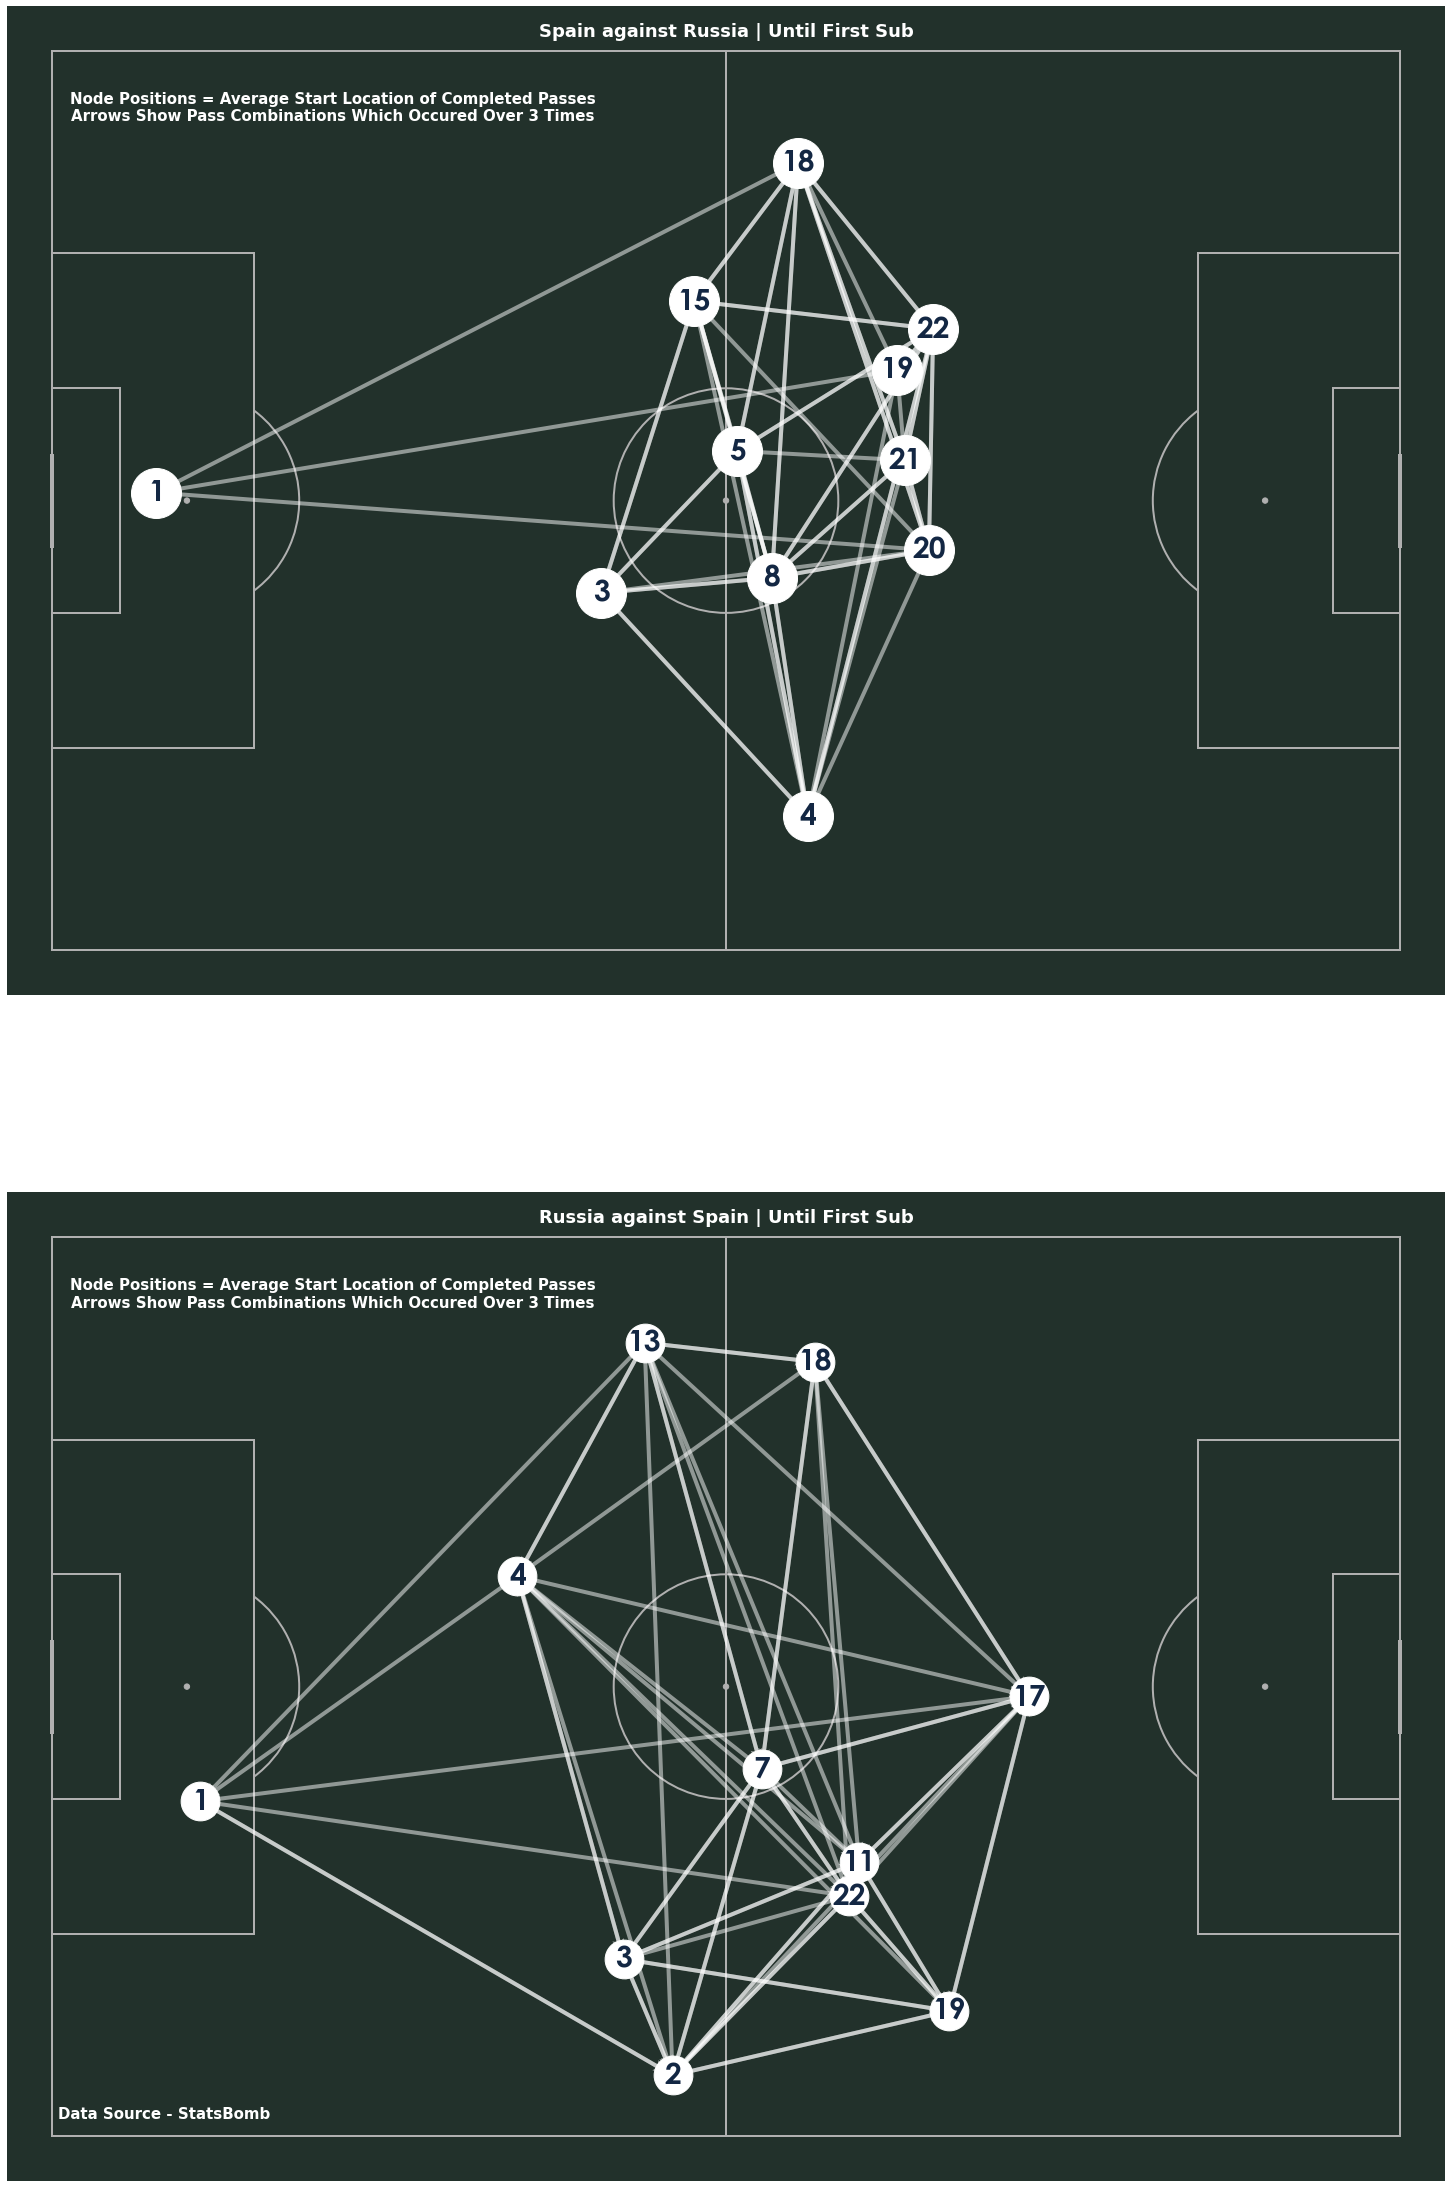

In [5]:
##Open the json and normalize
with open('spain_russia.json', encoding="utf8") as data_file:    
    data = json.load(data_file)
df = pd.json_normalize(data, sep = "_")

## Get the necessary dataframe for both the teams ready
spain_pass_btn , spain_avg_psn = build_net(df , 'Spain')
rus_pass_btn , rus_avg_psn = build_net(df , "Russia")

##Draw the passing networks for both teams
draw_network(spain_pass_btn , spain_avg_psn , rus_pass_btn , rus_avg_psn , "Spain" , "Russia")

Enter jersey number for Antoine Griezmann 7
Enter jersey number for Benjamin Pavard 2
Enter jersey number for Blaise Matuidi 14
Enter jersey number for Hugo Lloris 1
Enter jersey number for Kylian Mbappé Lottin 10
Enter jersey number for Lucas Hernández Pi 21
Enter jersey number for N"Golo Kanté 13
Enter jersey number for Olivier Giroud 9
Enter jersey number for Paul Pogba 6
Enter jersey number for Raphaël Varane 4
Enter jersey number for Samuel Yves Umtiti 5


C:\Conda\lib\site-packages\pandas\core\generic.py:3887: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  obj = obj._drop_axis(labels, axis, level=level, errors=errors)


Enter jersey number for Cristian David Pavón 22
Enter jersey number for Enzo Nicolás Pérez 15
Enter jersey number for Faustino Marcos Alberto Rojo 16
Enter jersey number for Franco Armani 12
Enter jersey number for Gabriel Iván Mercado 2
Enter jersey number for Javier Alejandro Mascherano 14
Enter jersey number for Lionel Andrés Messi Cuccittini 10
Enter jersey number for Nicolás Alejandro Tagliafico 3
Enter jersey number for Nicolás Hernán Otamendi 17
Enter jersey number for Ángel Fabián Di María Hernández 11
Enter jersey number for Éver Maximiliano David Banega 7


C:\Conda\lib\site-packages\pandas\core\generic.py:3887: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  obj = obj._drop_axis(labels, axis, level=level, errors=errors)


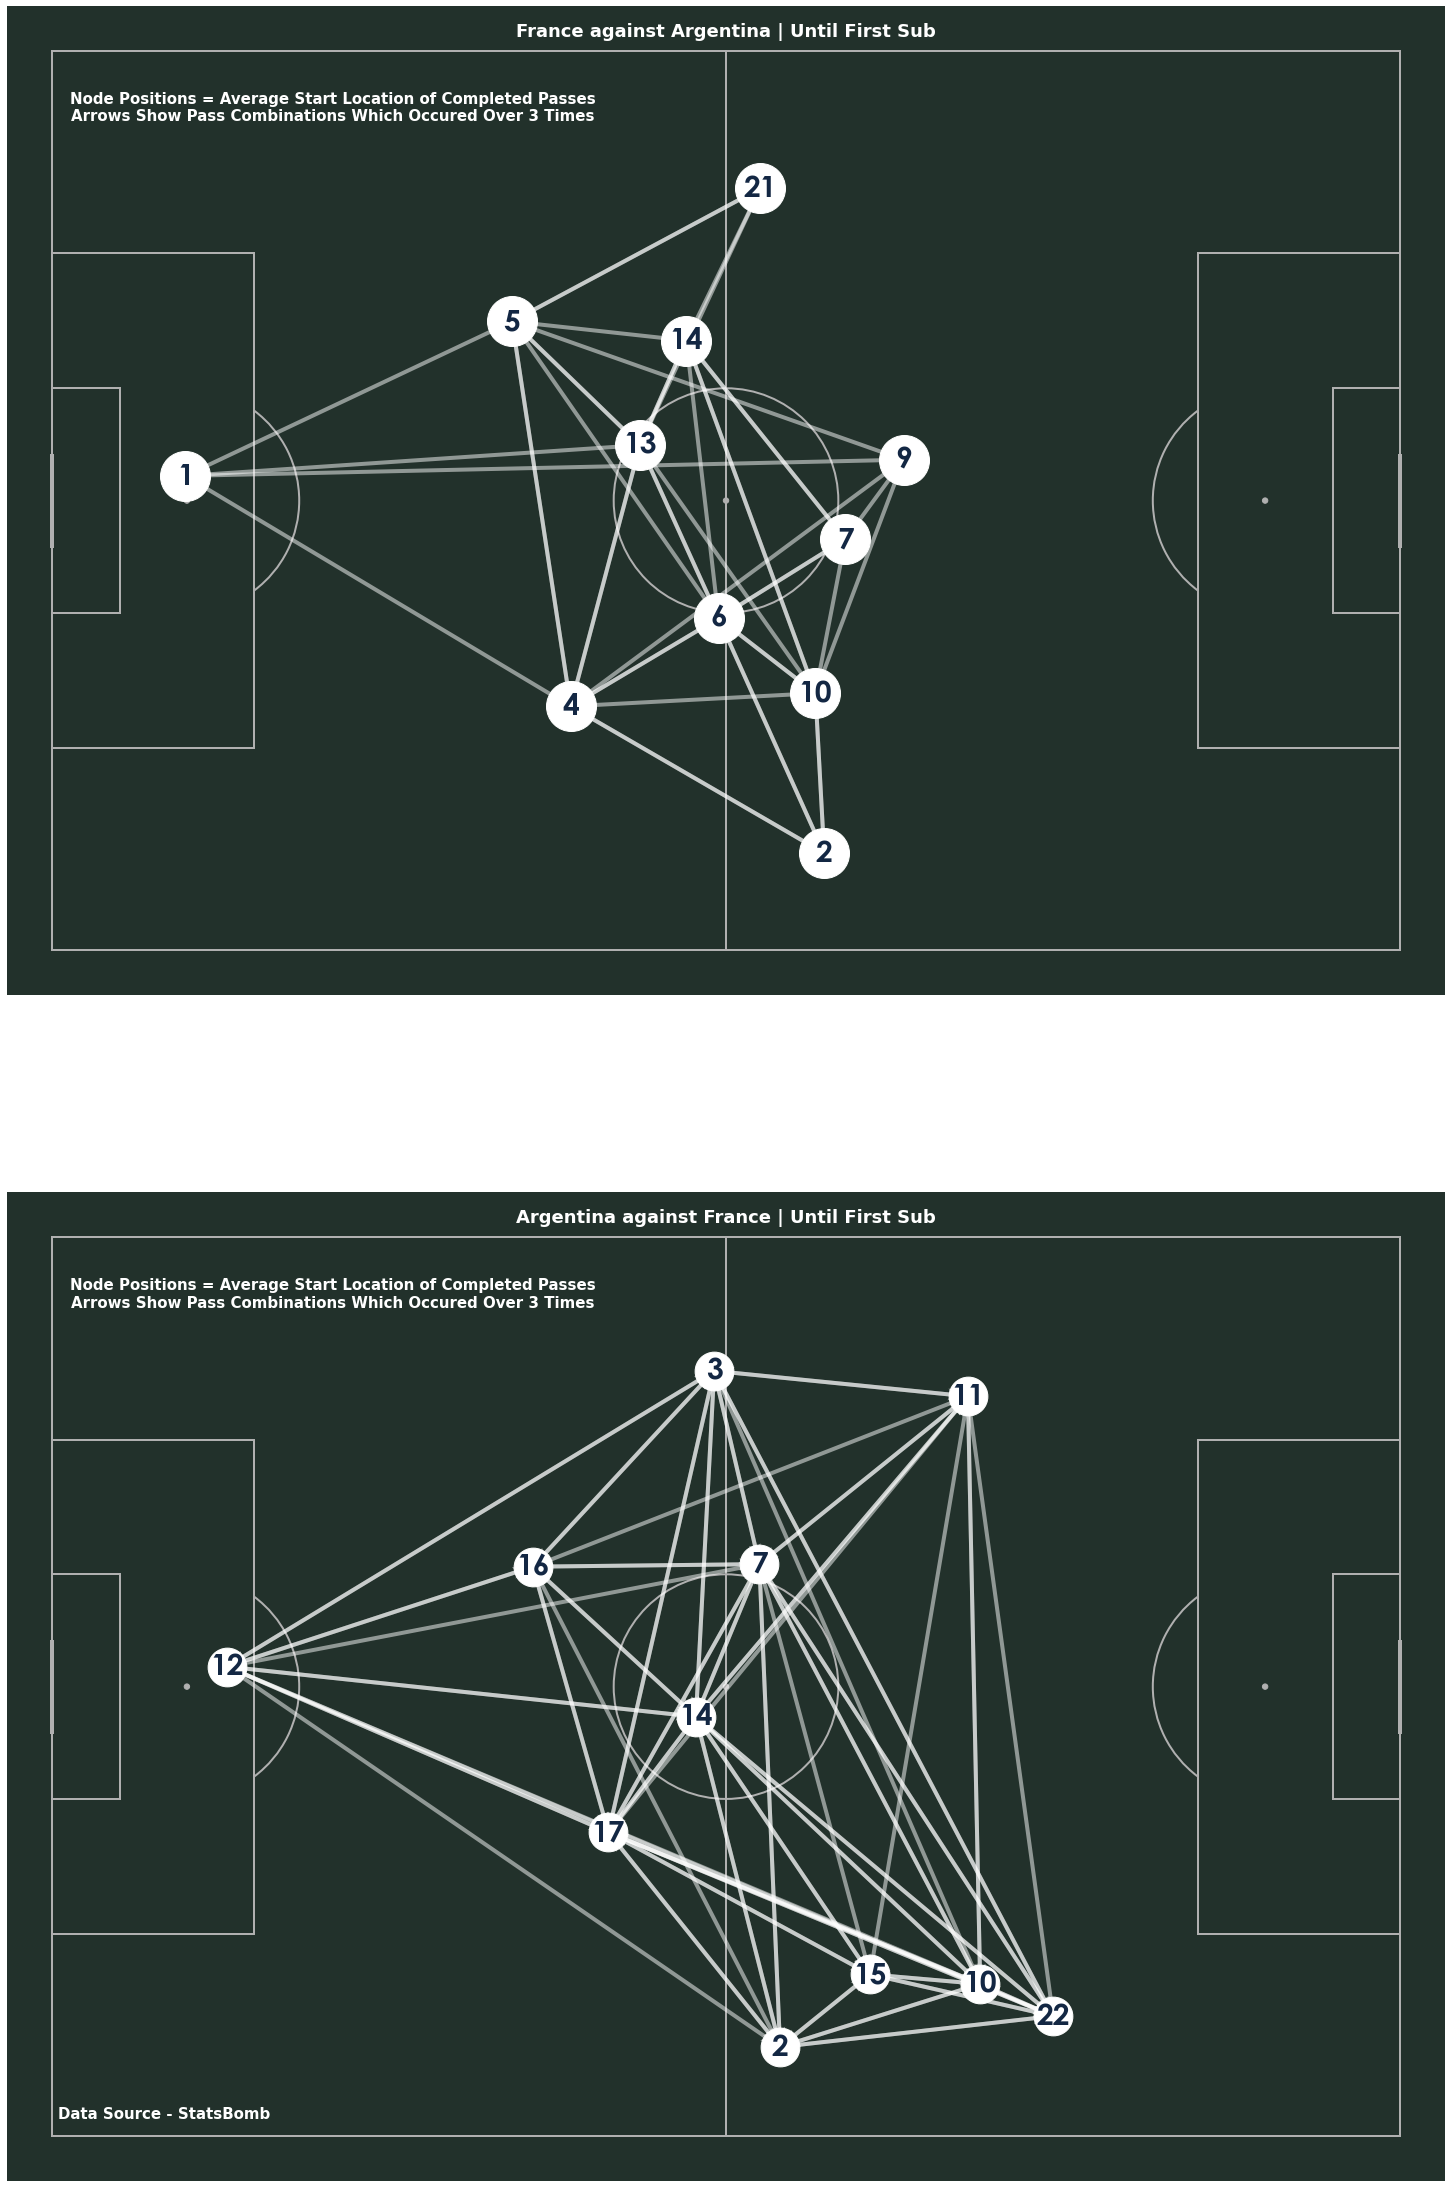

In [6]:
##This time let us try the France-Argentina game
##Open the json and normalize
with open('fra_arg.json', encoding="utf8") as data_file:    
    data = json.load(data_file)
df = pd.json_normalize(data, sep = "_")

## Get the necessary dataframe for both the teams ready
spain_pass_btn , spain_avg_psn = build_net(df , 'France')
rus_pass_btn , rus_avg_psn = build_net(df , "Argentina")

##Draw the passing networks for both teams
draw_network(spain_pass_btn , spain_avg_psn , rus_pass_btn , rus_avg_psn , "France" , "Argentina")